# Digit recognition - multiclass classification


## Processing of collected data (not MNIST)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
import skimage.io as skio
zeros = skio.imread_collection("website/images/0/*.png")
ones = skio.imread_collection("website/images/1/*.png")
twos = skio.imread_collection("website/images/2/*.png")
threes = skio.imread_collection("website/images/3/*.png")
fours = skio.imread_collection("website/images/4/*.png")
fives = skio.imread_collection("website/images/5/*.png")
sixes = skio.imread_collection("website/images/6/*.png")
sevens = skio.imread_collection("website/images/7/*.png")
eights = skio.imread_collection("website/images/8/*.png")
nines = skio.imread_collection("website/images/9/*.png")

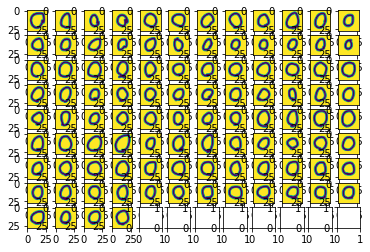

In [29]:
skio.imshow_collection(zeros);

## Inverting, binarizing

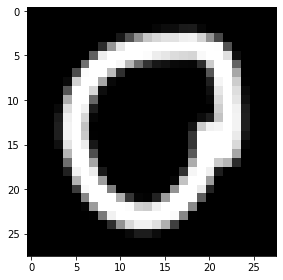

In [40]:
import skimage.color as skclr
import skimage.filters as skfltr


# Standard inverted
zeros_inv = np.invert(zeros[0])
skio.imshow(zeros_inv)

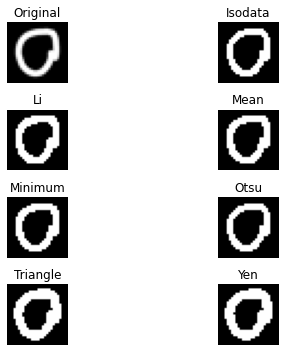

In [45]:
skfltr.try_all_threshold(zeros_inv, verbose=False);

In [56]:
# Choosing Otsu as the best threshold
def binarize_images(image_collection):
    """
    Inverts a collection of images and makes it binary
    """

    imges = []

    for img in image_collection:
        thresh = skfltr.threshold_mean(img)
        binary = img < thresh
        imges.append(binary)
    
    return imges

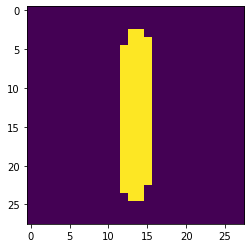

In [60]:
plt.imshow(binarize_images(ones)[7])

In [61]:
zeros = binarize_images(zeros)
ones = binarize_images(ones)
twos = binarize_images(twos)
threes = binarize_images(threes)
fours = binarize_images(fours)
fives = binarize_images(fives)
sixes = binarize_images(sixes)
sevens = binarize_images(sevens)
eights = binarize_images(eights)
nines = binarize_images(nines)

## ToDo